In [1]:
import pandas as pd
from collections import Counter
import networkx as nx
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.graph_objects as go

init_notebook_mode(connected=True)
import random
import colorlover as cl
from IPython.display import HTML
import plotly
import matplotlib.pyplot as plt

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from collections import Counter
import re

%matplotlib inline


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jianhuili/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Q1: Choose a hash-tag #facebook

In [2]:
df = pd.read_csv("tweets2009-06-0115.csv", sep='\t')

In [3]:
df.head()

date        user          tweet
0  2009-06-01 21:43:59  burtonator  No Post Title
1  2009-06-01 21:47:23  burtonator  No Post Title
2  2009-06-02 01:15:44  burtonator  No Post Title
3  2009-06-02 05:17:52  burtonator  No Post Title
4  2009-06-02 23:58:25  burtonator  No Post Title

In [4]:
df.shape

(3437690, 3)

In [5]:
allTweets = df["tweet"].str.cat(sep=' ')
tweetWords = [word.strip(""" ,.:'\";""").lower() for word in allTweets.split()]
hashTags = [word for word in tweetWords if word.startswith("#")]
hashTagsCounter = Counter(hashTags)

In [6]:
hashTagsCounter.most_common(100)

[('#iranelection', 26853),
 ('#followfriday', 16400),
 ('#jobs', 13322),
 ('#iremember', 11057),
 ('#spymaster', 10587),
 ('#ff', 10446),
 ('#squarespace', 9198),
 ('#tcot', 7691),
 ('#fb', 6107),
 ('#cnnfail', 4451),
 ('#11thcommandment', 3429),
 ('#jtv', 3317),
 ('#140mafia', 3144),
 ('#iran', 2935),
 ('#', 2895),
 ('#news', 2837),
 ('#quote', 2750),
 ('#vampirebite', 2634),
 ('#1', 2587),
 ('#bsb', 2433),
 ('#tweetmyjobs', 2086),
 ('#iphone', 1697),
 ('#lastfm', 1599),
 ('#mp2', 1589),
 ('#niley', 1528),
 ('#music', 1489),
 ('#p2', 1439),
 ('#follow', 1390),
 ('#pawpawty', 1305),
 ('#hhrs', 1256),
 ('#fail', 1246),
 ('#twitter', 1216),
 ('#tlot', 1214),
 ('#facebook', 1177),
 ('#sgp', 1151),
 ('#mashchat', 1143),
 ('#tinychat', 1111),
 ('#2', 1107),
 ('#digg', 1102),
 ('#gop', 1009),
 ('#phish', 1001),
 ('#mlb', 962),
 ('#travel', 932),
 ('#bonnaroo', 887),
 ('#twitpocalypse', 879),
 ('#iranelections', 857),
 ('#rt', 856),
 ('#zensursula', 811),
 ('#jamlegend', 790),
 ('#quotes', 75

In [7]:
facebookTag = df[df["tweet"].str.lower().str.contains("#facebook", na=False)].copy()

In [8]:
facebookTag.head()  # size 1117

date       user  \
5639   2009-06-11 17:08:04      kwech   
21157  2009-06-11 17:26:38        vjt   
25643  2009-06-11 17:34:56  studiomds   
28973  2009-06-11 17:41:25   nextmoon   
40133  2009-06-11 17:59:19    mikemdm   

                                                   tweet  
5639   You have one and a half days to choose your Fa...  
21157  ~ #EFF Launches TOSBack, a "Terms of Service" ...  
25643  @garyvee facebook vanity url alternative for t...  
28973  RT @StefanW: "Social Media Addiction" by @ jfo...  
40133  http://tr.im/oazp #facebook marketing book (fr...

In [9]:
def addMentionedColumn(df):
    
    def mentionsList(txt):
        allWords = [word.strip(""" ,.:'\";""").lower() for word in txt.split()]
        allNames = [word.strip("@") for word in allWords if word.startswith("@")]
        uniqueNames = list(set(allNames))
        return allNames
    
    df["mentioned"] = df["tweet"].apply(mentionsList)

In [10]:
addMentionedColumn(facebookTag)

In [11]:
facebookTag.head(10)

date          user  \
5639   2009-06-11 17:08:04         kwech   
21157  2009-06-11 17:26:38           vjt   
25643  2009-06-11 17:34:56     studiomds   
28973  2009-06-11 17:41:25      nextmoon   
40133  2009-06-11 17:59:19       mikemdm   
40735  2009-06-11 17:59:57       ysamphy   
40895  2009-06-11 18:00:14  thelancelife   
66111  2009-06-11 18:40:08  theryangavin   
82502  2009-06-11 19:07:41        dwears   
86858  2009-06-11 19:15:08      gcdevine   

                                                   tweet  \
5639   You have one and a half days to choose your Fa...   
21157  ~ #EFF Launches TOSBack, a "Terms of Service" ...   
25643  @garyvee facebook vanity url alternative for t...   
28973  RT @StefanW: "Social Media Addiction" by @ jfo...   
40133  http://tr.im/oazp #facebook marketing book (fr...   
40735  Soon you'll have your custom #Facebook URL for...   
40895  seesmic #twitter and #facebook evolved : http:...   
66111  Oh, did I mention that #Mizzou has a fan page ...   
82502  Just added myself to the http://wefollow.com t...   
86858  you can pick a #FaceBook user name?! What the ...   

                       mentioned  
5639                          []  
21157  [velenux, googlepolicyit]  
25643                  [garyvee]  
28973                [stefanw, ]  
40133                         []  
40735                         []  
40895             [thelancelife]  
66111                         []  
82502                         []  
86858                         []

## Q2: Build a Mention Graph

In [12]:
def mentionGraph(df):
    g = nx.Graph()
    
    for (index, date, user, tweet, mentionedUsers) in df.itertuples():
        for mentionedUser in mentionedUsers:
            if (user in g) and (mentionedUser in g[user]):
                g[user][mentionedUser]["numberMentions"] += 1
            else:
                g.add_edge(user, mentionedUser, numberMentions=1)
    
    return g

In [13]:
facebookGraph = mentionGraph(facebookTag)

### (a) How many nodes and how many edges in your mention graph?

In [14]:
print("# nodes:", len(facebookGraph.nodes()))
print("# edges:", len(facebookGraph.edges()))

# nodes: 746
# edges: 542


In [15]:
#facebookGraph.edges()

### (b) Build a histogram of the graph nodes’ degree (i.e., the degree distribution of the graph). What can you learn from the degree distribution?

Among the 746 data, majority of the nodes have very small number of degree.i.e 573/746 have degree 1, 112/746 have degree 2. Only 13 nodes have degree higher than 5. The highest degree is 29. numberMentions >=1

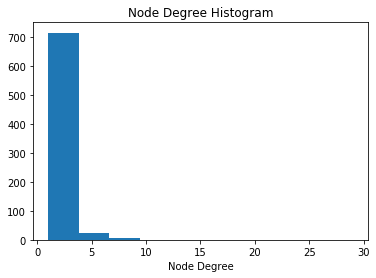

In [16]:
list_degree=dict(nx.degree(facebookGraph)).values()


plt.hist(list_degree)
plt.title("Node Degree Histogram")
plt.xlabel("Node Degree")
plt.show()

In [17]:
sorted(list_degree,reverse=True)

[29,
 16,
 10,
 8,
 8,
 8,
 7,
 7,
 7,
 6,
 6,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 

In [18]:
def countweightforedge(graph):
    edge = {}
    for (node1,node2) in graph.edges():
        edgeWidth = graph[node1][node2]['numberMentions']
        edge[(node1,node2)] = edgeWidth
    return edge

In [19]:
facebook_edge = countweightforedge(facebookGraph)

### (c) Provide a list of top 5 edges with highest weights (edges are identified be the two nodes they connects, e.g., ⟨node1, node2⟩).

In [20]:
sorted(facebook_edge.items(), key=lambda x: -x[1])[:5]

[(('rondostar', 'levelten_colin'), 6),
 (('bullconsulting', 'pachanyc'), 5),
 (('photoshoptips', 'thomasbregulla'), 4),
 (('babysherlene', 'laibcoms'), 4),
 (('mayhemstudios', 'spndrm'), 4)]

In [21]:

def addRandomPositions(graph):
    posDict = dict((node,(random.gauss(0,10),random.gauss(0,10))) for node in graph.nodes())
    nx.set_node_attributes(graph, name="pos", values=posDict)

In [22]:
addRandomPositions(facebookGraph)

In [23]:
def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [24]:
def plotNetworkSizeColor(graph):
    maxwidth = max(countweightforedge(graph).values())
    minwidtn = min(countweightforedge(graph).values())

    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        edgeColor = int(299*(edgeWidth-minwidtn)/(maxwidth-minwidtn))

        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='text',
                mode='lines', 
                text="Edge: %s\Weight: %f" % ((node1,node2), edgeWidth),
                line=scatter.Line(width=edgeWidth ,color=purd300[edgeColor]))
        scatters.append(s)



    for node in graph.nodes():
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                hoverinfo='none',
                mode='markers', 
                marker=dict(
                    color="#888", 
                    size=2,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [25]:
# map purd color scale to 300 cells
purd = cl.scales['9']['seq']['PuRd']
purd300 = cl.interp(purd, 300)
HTML(cl.to_html(purd300))

### (d) Provide a visualization of the mention graph in which the edge color reflects its weight (i.e., the number of mentions)

In [26]:
configure_plotly_browser_state()
plotNetworkSizeColor(facebookGraph)


## Q3. Content Analysis

In [27]:
facebookTag['tweet'][:20]

5639      You have one and a half days to choose your Fa...
21157     ~ #EFF Launches TOSBack, a "Terms of Service" ...
25643     @garyvee facebook vanity url alternative for t...
28973     RT @StefanW: "Social Media Addiction" by @ jfo...
40133     http://tr.im/oazp #facebook marketing book (fr...
40735     Soon you'll have your custom #Facebook URL for...
40895     seesmic #twitter and #facebook evolved : http:...
66111     Oh, did I mention that #Mizzou has a fan page ...
82502     Just added myself to the http://wefollow.com t...
86858     you can pick a #FaceBook user name?! What the ...
110938    Hey #Transformers fans, enter our #video uploa...
122167    Join #Facebook and sign up for our eNewsletter...
133194    prevent your brand username on #facebook using...
137752    #facebook Using Facebook for business free ebo...
158715    Have a trademark you want a #Facebook URL for ...
163585    Starting on Saturday, June 13th, at 12:01pm, y...
167740    And the saga continues - more 

In [28]:
def getTopK(df, k, value_column='tweet'):
    stop = set(stopwords.words('english'))
    counter = Counter()
    for twt in df[value_column]:
            counter.update([word.lower() for word in re.findall(r'\w+', twt) if word not in stop and len(word) > 2])
    topk = counter.most_common(k)
    return topk

### (a) Analyze the most common words in all the tweets with the chosen hash-tag, and provide a basic description of the main themes.

It seems the top tweet for hashtag #facebook are related to ask for being followed, and social media platform, like twitter.

In [29]:
getTopK(facebookTag,50)

[('facebook', 2083),
 ('http', 1177),
 ('com', 773),
 ('www', 457),
 ('username', 302),
 ('bit', 273),
 ('url', 197),
 ('vanity', 162),
 ('twitter', 140),
 ('usernames', 103),
 ('get', 93),
 ('2009', 93),
 ('got', 90),
 ('name', 83),
 ('the', 71),
 ('tinyurl', 63),
 ('new', 62),
 ('just', 55),
 ('page', 53),
 ('available', 43),
 ('urls', 42),
 ('mashable', 41),
 ('you', 40),
 ('socialmedia', 39),
 ('first', 39),
 ('fan', 38),
 ('minutes', 38),
 ('vanityurl', 34),
 ('via', 34),
 ('grab', 33),
 ('google', 32),
 ('000', 32),
 ('social', 31),
 ('like', 31),
 ('how', 31),
 ('tonight', 30),
 ('time', 29),
 ('facebookvanity', 29),
 ('mine', 28),
 ('friends', 28),
 ('ich', 28),
 ('good', 27),
 ('bio', 26),
 ('last', 25),
 ('also', 25),
 ('for', 24),
 ('media', 23),
 ('please', 23),
 ('auch', 23),
 ('profile', 22)]

###  (b) In the visualization of the mention graph, add hover information for the nodes, describing the 3 most common words for this user. Add any other hover information that may help you understand the social network better.

In [30]:
import operator

##operator.eq
def getTopKuser(df, k, label_value, label_column='user', operation=operator.eq, value_column='tweet'):
    stop = set(stopwords.words('english'))
    
    counter = Counter()
    for twt in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update([word.lower() for word  in re.findall(r'\w+', twt)  if word not in stop and len(word) > 2 and word.isalpha()])
    topk = counter.most_common(k)
    return topk

In [31]:
def plotNetwork_usertop3(graph):
    maxMention = max(countweightforedge(graph).values())
    minMention = min(countweightforedge(graph).values())
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        nodeColor = int(299*(edgeWidth-minMention)/(maxMention-minMention))
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='text',
                text = "Edge: %s\Weight: %f" % ((node1,node2), edgeWidth),
                mode='lines', 
                line=Line(width=edgeWidth ,color=purd300[nodeColor]))
        scatters.append(s)



    for node in graph.nodes():
        xPos, yPos = graph.nodes[node]['pos']
        top3 = getTopKuser(facebookTag,k=3,label_value=node)
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                hoverinfo='text',
                text='Node: %s,Top words: %s'%(node,top3),
                mode='markers', 
                marker=dict(
                    color="#888", 
                    size=2,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [32]:
def applyLayout(graph, layoutFunc):
    posDict = layoutFunc(graph) 
    nx.set_node_attributes(graph, name="pos", values=posDict)
    

In [33]:
facebookGraph_usertop3 = facebookGraph.copy()
configure_plotly_browser_state()
plotNetwork_usertop3(facebookGraph_usertop3)

/Users/jianhuili/opt/anaconda3/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [34]:
facebook_top3 = facebookGraph.copy()
applyLayout(facebook_top3, nx.spring_layout)
configure_plotly_browser_state()
plotNetwork_usertop3(facebook_top3)

## Q4. Centrality Analysis

###  (a) Choose two centrality measures and calculate the centrality of the nodes on your graph based on each of the measures.  
Degree centrality

Betweenness centrality

In [35]:
degree_centrality = nx.degree_centrality(facebookGraph)

In [36]:
betweenness_centrality= nx.betweenness_centrality(facebookGraph)

In [37]:
def plotNetworkCentrality(graph,centrality):
    maxCentr = max(centrality.values())
    minCentr = min(centrality.values())
    
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color='#888'))
        scatters.append(s)



    for node in graph.nodes():
        nodeCentr = centrality[node]
        nodeColor = int(299*(nodeCentr-minCentr)/(maxCentr-minCentr))
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text="User: %s\ncCntrality: %.3f" % (node, nodeCentr),
                hoverinfo='text',
                mode='markers', 
                marker=dict(
                    color=purd300[nodeColor], 
                    size=nx.degree(graph,node)*2,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

#### Degree centrality

In [38]:
facebookGraph_q4 = facebookGraph.copy()
configure_plotly_browser_state()
plotNetworkCentrality(facebookGraph_q4,degree_centrality)

#### betweenness centrality

In [39]:
facebookGraph_q42 = facebookGraph.copy()
configure_plotly_browser_state()
plotNetworkCentrality(facebookGraph_q42,betweenness_centrality)

### (c) Identify the key players in the mentioned graph based on the centrality measures.
#### 1. Are the results similar or different? Explain what can be the reason for the observed similarity or difference.
It can be shown that even the node with top centrality with 2 methods are same, but most of the results are different. The scores are different. More color darkness means higher centrality.

Degree centrality consider the number of ties that a node has. Betweenness centrality consider quantifies the number of times a node acts as a bridge along the shortest path between two other nodes. they use different calculation method, but they can both identify the most important vertices within a graph. 

#### 2. What centrality measure produced a more meaningful interpretation? Why?
Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes. It is a measure for quantifying the control of a human on the communication between other humans in a social network. Therefore, using betweenness centrality to analyze centrality of users for social network is more suitable. 


## Q5. Connectivity Patterns

### (a) Calculate two or more of the following measures to analyze cliques in your mention graph:

#### 1. Number of maximal cliques in your graph.

In [40]:
maxCliques = nx.graph_number_of_cliques(facebookGraph)
maxCliques

502

#### 2. The graph’s clique number (size of the largest clique in the graph). (clique number of the graph.)

In [41]:
graph_clique_number = nx.graph_clique_number(facebookGraph)
graph_clique_number

3

#### 3. Number of maximal cliques for each node

In [42]:
maximal_cliques_for_each_node= nx.number_of_cliques(facebookGraph)
maximal_cliques_for_each_node_sorted = sorted(maximal_cliques_for_each_node.items(), key=lambda x: x[1], reverse=True)
maximal_cliques_for_each_node_sorted

[('mashable', 28),
 ('cspenn', 13),
 ('enavarroa', 10),
 ('', 7),
 ('mmidas', 7),
 ('scottmonty', 7),
 ('stefanw', 6),
 ('hashsocial', 6),
 ('legmar', 6),
 ('tameco', 6),
 ('majiwater', 6),
 ('lotay', 5),
 ('jbo', 5),
 ('senthilnambi', 5),
 ('staceycoxall', 4),
 ('paavani', 4),
 ('photoshoptips', 4),
 ('bjschone', 4),
 ('babysherlene', 4),
 ('derwesten', 4),
 ('bitboutique', 4),
 ('techcrunch', 4),
 ('stoansteirer', 4),
 ('visalusmiko', 4),
 ('sharonhayes', 4),
 ('wsjandy', 3),
 ('krisolin', 3),
 ('delicatesa', 3),
 ('malfunctional', 3),
 ('kiat', 3),
 ('fedeaikawa', 3),
 ('janagu', 3),
 ('dani', 3),
 ('cyantist', 3),
 ('iizliz', 3),
 ('stevievep', 3),
 ('alleyinsider', 3),
 ('bill21430', 3),
 ('susuh', 3),
 ('cnetnews', 3),
 ('two_ot', 3),
 ('saloff', 3),
 ('rtsocialmedia', 3),
 ('sadekhm', 3),
 ('thevideotube', 3),
 ('hourlytechdeals', 3),
 ('vjt', 2),
 ('nextmoon', 2),
 ('searchfeed', 2),
 ('ghadalancer', 2),
 ('jaybaer', 2),
 ('rkartha', 2),
 ('realmtnboy', 2),
 ('elavrov', 2),
 ('

#### 4. Size of the largest maximal clique containing each given node.

In [43]:
each_given_node= nx.node_clique_number(facebookGraph)
each_given_node_sorted=sorted(each_given_node.items(), key=lambda x: x[1], reverse=True)
each_given_node_sorted

[('mmidas', 3),
 ('mashable', 3),
 ('hashsocial', 3),
 ('scottmonty', 3),
 ('cspenn', 3),
 ('the_beth', 3),
 ('adityarao310', 3),
 ('cincyrecruiter', 3),
 ('susanbeebe', 3),
 ('rmercader', 3),
 ('jeffrago', 3),
 ('knowinsky', 3),
 ('zoic', 3),
 ('rupprecht', 3),
 ('juergenzahrl', 3),
 ('benparr', 3),
 ('edei', 3),
 ('cyantistjust', 3),
 ('dshelleny', 3),
 ('nrek', 3),
 ('cyantist', 3),
 ('yinh', 3),
 ('manch', 3),
 ('shindotv', 3),
 ('k4rl0z', 3),
 ('god', 3),
 ('will_ms', 3),
 ('tameco', 3),
 ('scheibenhacker', 3),
 ('sebi_veltkamp', 3),
 ('basticore', 3),
 ('susuh', 3),
 ('argus27', 3),
 ('rtsocialmedia', 3),
 ('timmoore', 3),
 ('spydergrrl', 3),
 ('vjt', 2),
 ('velenux', 2),
 ('googlepolicyit', 2),
 ('studiomds', 2),
 ('garyvee', 2),
 ('nextmoon', 2),
 ('stefanw', 2),
 ('', 2),
 ('thelancelife', 2),
 ('wsjandy', 2),
 ('guerillafutures', 2),
 ('jimpish', 2),
 ('lotay', 2),
 ('atlgrrrl4life', 2),
 ('chrislovecnm', 2),
 ('marcrapp', 2),
 ('jennifertice', 2),
 ('justmikeyhrc', 2),
 ('ma

In [44]:
sum(x==3 for x in each_given_node.values())

36

In [45]:
sum(x==2 for x in each_given_node.values())

705

In [46]:
sum(x==1 for x in each_given_node.values())

5


### (b) Provide some insights on the connectivity patterns of your mention graph based on the in- formation calculated in (a). What was the largest clique? How large was it? What else do your clique properties and cliques themselves tell you about the social network?

a) A maximal clique is a clique that cannot be extended by including one more adjacent vertex

To summarize the clique data in the first part.

 nodes: 746
 edges: 542
 
 We have 502 distinct maximal cliques of size 1 or 2 or 3.
 
 Most of the nodes 705/746 have the largest clique size of 2, while only 36/746 have size of 3. And 5/746 has clique size of 1, meaning it's isolated from all other nodes/users.
 
 606/746 nodes have only 1 maximal cliques, 96/746 have 2, and only 3 nodes have more than 10 maximal cliques.
 
b) Insights

That means user in this hashtag netword is not strongly connected. 606 Nodes having 1 maximal cliques meaning that each of them only connects to another user, so that to form multiple isolated user pairs. There are 3 users have more than 10 maximal cliques.('mashable', 28),('cspenn', 13),('enavarroa', 10), That means they might be the centrer of certain topics related to this hashtag.

36 nodes are in the maximal cliques of 3, that means the largest component after betweeness clustering will be 3. That is: the maximum size of group that knows each other and interact with each other is 3.